In [29]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [60]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [31]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [32]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [33]:
airi_dat

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) datetime64[ns] 1871-02-01 1871-03-01 ... 2017-01-01
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0

In [34]:
precip = airi_dat['precip']

In [35]:
#Load SLP data
dataset_file = "slp.mnmean.real.nc"
slp_dat = xr.open_dataset(dataset_file)
#slp_dat = xr.open_dataset(dataset_file, decode_times=False)
#units, reference_date = slp_dat.time.attrs['units'].split('since')
#slp_dat['time'] = pd.date_range(start=reference_date, periods=slp_dat.sizes['time'], freq='MS')
slp = slp_dat['slp']

In [36]:
slp_dat

<xarray.Dataset>
Dimensions:    (lat: 37, lon: 72, nbnds: 2, time: 2029)
Coordinates:
  * lat        (lat) float32 90.0 85.0 80.0 75.0 ... -75.0 -80.0 -85.0 -90.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-01-01
Dimensions without coordinates: nbnds
Data variables:
    slp        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) float64 ...
Attributes:
    title:        HadSLP2
    history:      Fri Mar  8 10:06:25 2013: ncks -d time,0,1957 slp.mnmean.re...
    comments:     adSLP2 was created using marine observations taken from ICO...
    Conventions:  CF-1.0
    platform:     Model
    source:       Hadley Center
    institution:  Hadley Center
    References:   https://www.esrl.noaa.gov/psd/data/gridded/data.hadslp2.html
    NCO:          20130308
    source_url:   https://hadobs.metoffice.com/hadslp2/

In [37]:
#Slice SLP data to the same duration as precip and calculate monthly anomalies
slp_subset = slp.sel(time=slice('1871-01-30','2017-01-01'))
slp_clim = slp_subset.groupby('time.month').mean('time')
slp_anomfull = slp_subset.groupby("time.month")-slp_clim
slp_anomfull
slp_anom = slp_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))

In [38]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

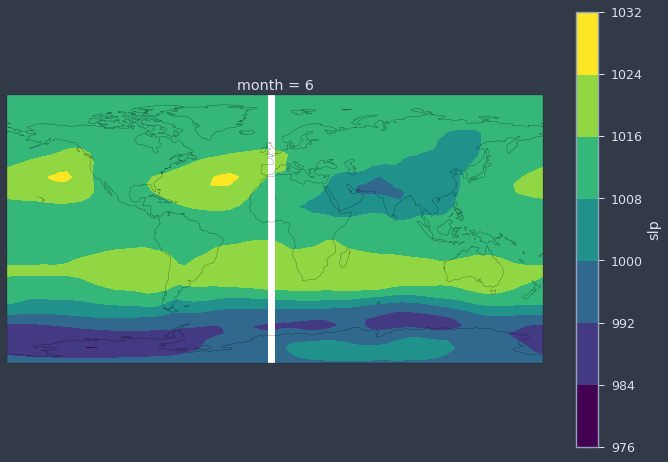

In [39]:
#Test plot of slp_clim

ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(slp_clim.sel(month=6))
slp_clim.sel(month=6).plot.contourf()
ax.coastlines(color='black')
#ax.add_patch(mpatches.Rectangle(xy=[-40,-160], width=30, height=70, facecolor=None, edgecolor='white', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#ax.set_extent([-30,160,0,40],crs=ccrs.PlateCarree(central_longitude=0)); 

#(40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)mega-ENSOpredictorNATMay minus March SLP averaged over(45°N–60°N, 95°E–125°E)Anomalous
    
#plt.colorbar()
#did i do this wrong, not able to see the land masses in black, or do land masses also have slp

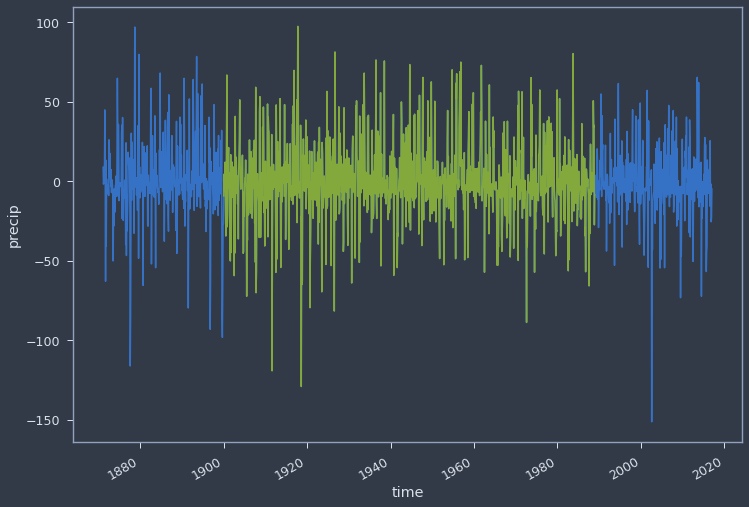

In [40]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim
precip_anom = precip_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))
precip_anomfull.plot()
precip_anom.plot()

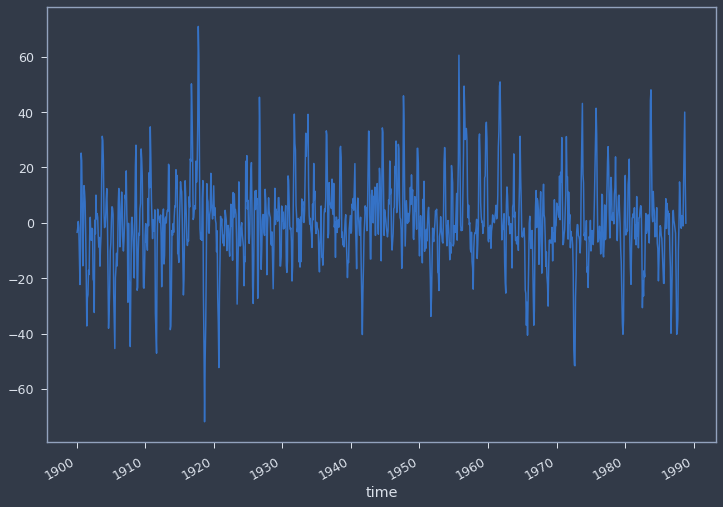

In [41]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [42]:
#Seasonal means of SLPA
slpa_seasonal = slp_anom.rolling(time=3,center=True).mean()
slpa_seasonal

<xarray.DataArray (time: 1068, lat: 37, lon: 72)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[ 7.108643,  7.108643, ...,  7.108643,  7.108643],
        [ 6.665344,  7.013184, ...,  6.513733,  6.479574],
        ...,
        [ 0.648376,  0.822856, ...,  0.617025,  0.612366],
        [ 1.592875,  1.592875, ...,  1.592875,  1.592875]],

       ...,

       [[-5.521606, -5.521606, ..., -5.521606, -5.521606],
        [-4.017782, -3.657837, ..., -4.068685, -4.343729],
        ...,
        [ 1.011454,  1.018209, ...,  0.837117,  0.943034],
        [ 1.103577,  1.103577, ...,  1.103577,  1.103577]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       

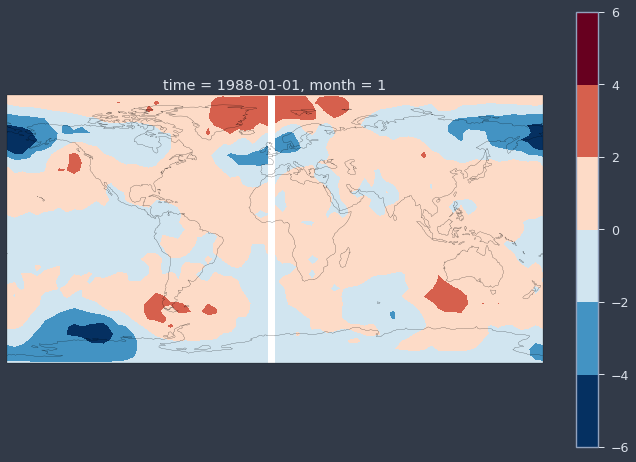

In [43]:
#Test plot of seasonal SLP anomalies in DJF 1997-8
#plt.contourf(slpa_seasonal.sel(time='1998-01-01'))
#plt.colorbar()
ax = plt.axes(projection=ccrs.PlateCarree())
slpa_seasonal.sel(time='1988-01-01').plot.contourf()
ax.coastlines()

In [44]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [45]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = slpa_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
slp_r = correlation(x, y, dims='time')
#y = slpa_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)')

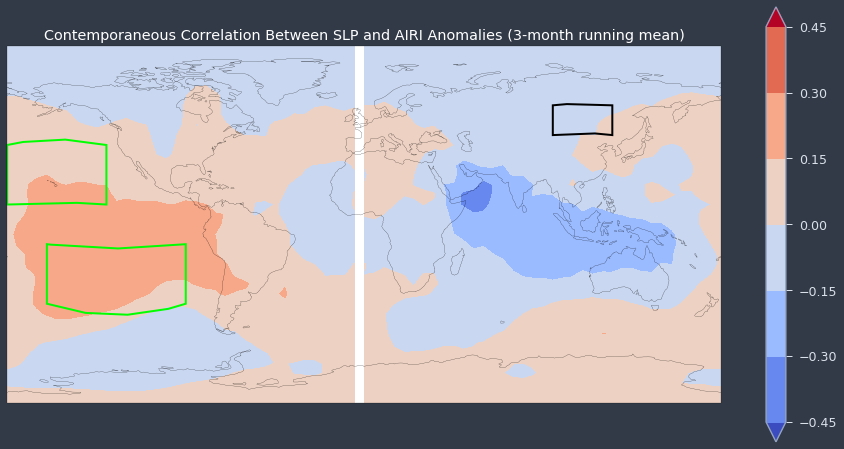

In [61]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)', color = 'white')

In [62]:
#Try the same with only JJA:
julys=np.arange(6,1068,12)
slpa_jja = slpa_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
slp_jja_r = correlation(slpa_jja,precipa_jja,dims='time')

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)')

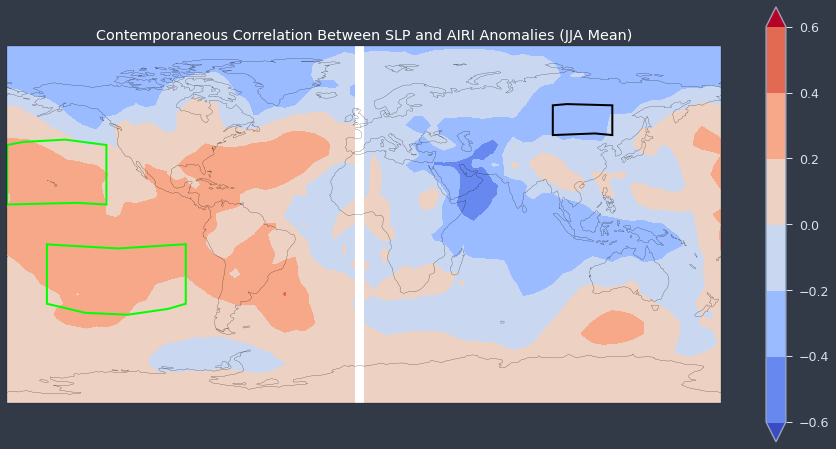

In [63]:
#Plot JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_jja_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_jja_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)', color = 'white')

In [64]:
#Try this with a lag of 3 months
slpa_seasonal_3shift = slpa_seasonal.shift(time=-3)
slpa_mam = slpa_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted SLPA (by 3 months)')

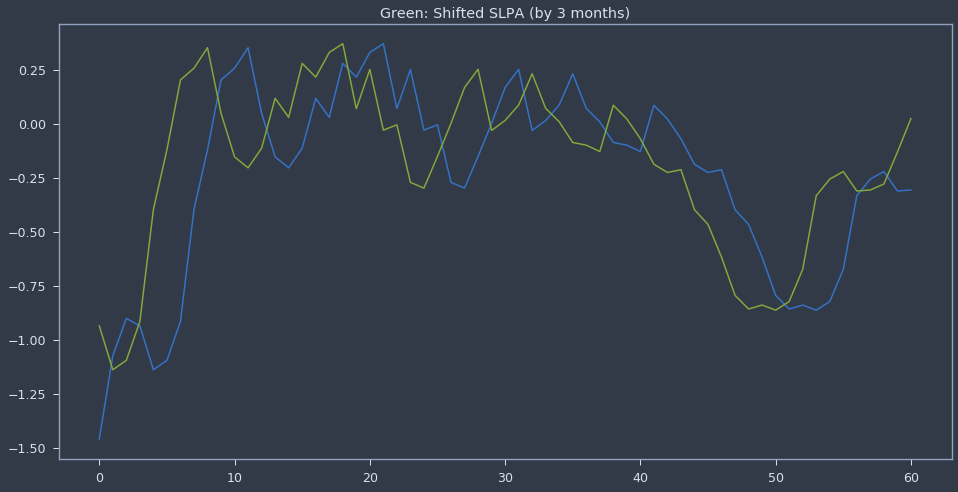

In [65]:
plt.plot(slpa_seasonal.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.plot(slpa_seasonal_3shift.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.title('Green: Shifted SLPA (by 3 months)')

In [66]:
#Run correlation
slp_mam_r = correlation(slpa_mam,precipa_jja,dims='time')
print(slp_mam_r)

<xarray.DataArray (lat: 37, lon: 72)>
array([[-0.191606, -0.191606, -0.191606, ..., -0.191606, -0.191606, -0.191606],
       [-0.170883, -0.18963 , -0.214083, ..., -0.162286, -0.169837, -0.169318],
       [-0.141379, -0.170552, -0.204753, ..., -0.13688 , -0.127502, -0.126561],
       ...,
       [ 0.011981,  0.016071,  0.023204, ...,  0.000296,  0.007448,  0.010186],
       [ 0.033393,  0.035983,  0.040064, ...,  0.030114,  0.032249,  0.032635],
       [ 0.041392,  0.041392,  0.041392, ...,  0.041392,  0.041392,  0.041392]])
Coordinates:
  * lat      (lat) float32 90.0 85.0 80.0 75.0 70.0 ... -75.0 -80.0 -85.0 -90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0


Text(0.5, 1.0, 'Correlation Between MAM SLP and JJA AIRI Anomalies')

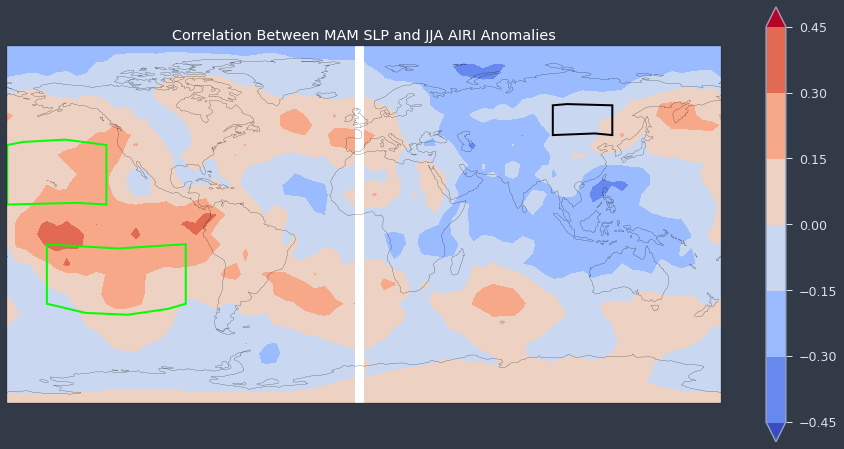

In [67]:
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.colorbar()
slp_mam_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between MAM SLP and JJA AIRI Anomalies', color = 'white')

In [68]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
slpa_2shift_dt = slp_anom-slp_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1068,12)
precipa_jjas = precipa_4seasonal[septembers]
slpa_2shift_dt_sep = slpa_2shift_dt.shift(time=4)[septembers,:,:]

In [69]:
slp_may_mar_r = correlation(slpa_2shift_dt_sep,precipa_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between May-March SLPA and JJAS AIRI Anomalies')

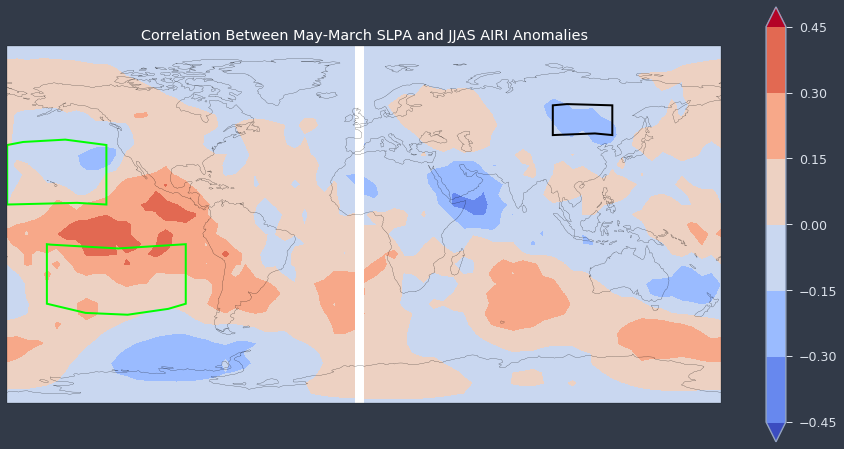

In [70]:
#Plot correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_may_mar_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_may_mar_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between May-March SLPA and JJAS AIRI Anomalies', color = 'white')

# moist static energy

In [71]:
# Load data
mse_dat1 = xr.open_dataset('data/ERA_Interim_MSE950.nc',decode_times=False)
#The original ferret coordinate names are non-standard so need to be renamed
mse_dat = mse_dat1.rename({'G4_LON_2': 'longitude','G4_LAT_1': 'latitude','LV_ISBL035_35':'level','MONTHAX':'time'})
#Calendar needs to be reformatted to be recognized by xarray (it doesn't recognize gregorian calendars?)
units, reference_date = mse_dat.time.attrs['units'].split('since')
mse_dat['time'] = pd.date_range(start=reference_date, periods=mse_dat.sizes['time'], freq='MS')
mse_dat

<xarray.Dataset>
Dimensions:               (MONTH_GREGORIAN: 12, bnds: 2, latitude: 256, level: 1, longitude: 512, time: 456)
Coordinates:
  * longitude             (longitude) float32 0.0 0.70312524 ... 359.297
  * latitude              (latitude) float32 -89.46282 -88.76695 ... 89.46282
  * level                 (level) int32 950
  * MONTH_GREGORIAN       (MONTH_GREGORIAN) float64 15.5 45.12 ... 319.2 349.7
  * time                  (time) datetime64[ns] 1979-01-01 ... 2016-12-01
Dimensions without coordinates: bnds
Data variables:
    G4_LON_2_bnds         (longitude, bnds) float32 ...
    G4_LAT_1_bnds         (latitude, bnds) float32 ...
    LV_ISBL035_35_bnds    (level, bnds) int32 ...
    MONTH_GREGORIAN_bnds  (MONTH_GREGORIAN, bnds) float64 ...
    MSE_CLIM              (MONTH_GREGORIAN, level, latitude, longitude) float64 ...
    MONTHAX_bnds          (time, bnds) float64 ...
    MSE_ANOM              (time, level, latitude, longitude) float64 ...
Attributes:
    history:     

In [72]:
mse_anom = mse_dat['MSE_ANOM'].squeeze(drop=True) #Drop levels dimension (the file only has values for 950 hPa)
mse_anom

<xarray.DataArray 'MSE_ANOM' (time: 456, latitude: 256, longitude: 512)>
[59768832 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.70312524 ... 358.59387 359.297
  * latitude   (latitude) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Attributes:
    long_name:               MSE-MSE_CLIM[GT=MSE@ASN]
    climatology_time_range:  JAN-1979:DEC-2016

In [73]:
#Make 3-month running mean to get seasonal means
#Seasonal means of SSTA
msea_seasonal = mse_anom.rolling(time=3,center=True).mean()
msea_seasonal

<xarray.DataArray (time: 456, latitude: 256, longitude: 512)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[  410.278053,   411.105577, ...,   407.703885,   408.543136],
        [  240.85753 ,   241.1407  , ...,   236.692466,   238.6718  ],
        ...,
        [-1765.666123, -1771.304713, ..., -1753.179569, -1759.044701],
        [-1539.164874, -1540.392023, ..., -1534.504288, -1537.047305]],

       ...,

       [[ 1407.892302,  1408.523667, ...,  1405.599915,  1406.424548],
        [ 1395.229767,  1396.97553 , ...,  1389.975284,  1392.255409],
        ...,
        [ 6566.277464,  6571.070489, ...,  6555.64742 ,  6561.098837],
        [ 6403.70355 ,  6405.267443, ...,  6399.4579  ,  6401.5326  ]],

       [[         nan,      

In [74]:
#Use subset of AIRI and calculate correlation
x = msea_seasonal[1:-1,:,:] #remove leading and trailing NaNs
y = precipa_seasonal.sel(time=slice(x.time[0],x.time[-1]))
mse_r = correlation(x,y,dims='time')
#print(x.time)
#print(y.time)

ValueError: indexes along dimension 'time' are not equal

In [ ]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(mse_r.longitude,mse_r.latitude,mse_r,lev,cmap='coolwarm',extend='both',transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)', color = 'white')
plt.show()

In [139]:
# Copyright (c) 2020 Medha Palavalli.